In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

from make_map import make_map

from file_util import load_matlab_data
# from channel_overlap import channel_overlap
from plot import plot_discharge
from metrics import *
from stratigraphy import sedimentograph
from spatial_dist import *
from shapely.geometry import shape, Point, Polygon, MultiLineString, MultiPoint, MultiPolygon
import rasterio
from rasterio.features import shapes

from osgeo import ogr, gdal, osr
from shapely.ops import transform, polygonize_full

import cPickle as pickle
import fiona

def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]
    
    output_raster = gdal.GetDriverByName('GTiff').Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    #writing output raster
    output_raster.GetRasterBand(1).WriteArray( array ) 
    output_raster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(32645)
    output_raster.SetProjection(srs.ExportToWkt())
    output_raster.FlushCache()

def latlong_to_index(pt, xmin, xmax, ymin, ymax, array_size):
    
    newx = int(array_size[1] * (pt[0] - xmin) / (xmax - xmin))
    newy = int(array_size[0] - array_size[0] * (pt[1] - ymin) / (ymax - ymin))
    
    return (newx, newy)



def create_shapefile_from_shapely_multi(features, filename,
                                        fields = {}, field_type = {},
                                        buffer_width = 0, spatial_ref = 32645):


    driver = ogr.GetDriverByName('Esri Shapefile')
    ds = driver.CreateDataSource(filename)

    srs = osr.SpatialReference()
    srs.ImportFromEPSG(spatial_ref)

    layer = ds.CreateLayer('', srs, ogr.wkbPolygon)

    # Add attributes
    fieldDefn = ogr.FieldDefn('id', ogr.OFTReal)
    layer.CreateField(fieldDefn)

    for f in fields.keys():
        fieldDefn = ogr.FieldDefn(f, field_type[f])
        layer.CreateField(fieldDefn)

    defn = layer.GetLayerDefn()


    for i in range(len(features)):

        poly = features[i].buffer(buffer_width)

        # Create a new feature (attribute and geometry)
        feat = ogr.Feature(defn)
        
        feat.SetField('id', i)

        for f in fields.keys():
            feat.SetField(f, fields[f][i])

        # Make a geometry from Shapely object
        geom = ogr.CreateGeometryFromWkb(poly.wkb)
        feat.SetGeometry(geom)

        layer.CreateFeature(feat)
        feat = geom = None  # destroy these


    # Save and close everything
    ds = layer = feat = geom = None

    
    
    
def create_tiff_from_shapefile(InputVector, OutputImage, RefImage):

    gdalformat = 'GTiff'
    datatype = gdal.GDT_Byte
    burnVal = 1 #value for the output image pixels

    ##########################################################
    # Get projection info from reference image
    Image = gdal.Open(RefImage, gdal.GA_ReadOnly)

    # Open Shapefile
    Shapefile = ogr.Open(InputVector)
    Shapefile_layer = Shapefile.GetLayer()

    # Rasterise
    Output = gdal.GetDriverByName(gdalformat).Create(OutputImage,
                                                     Image.RasterXSize,
                                                     Image.RasterYSize,
                                                     1,
                                                     datatype,
                                                     options=['COMPRESS=DEFLATE'])
    Output.SetProjection(Image.GetProjectionRef())
    Output.SetGeoTransform(Image.GetGeoTransform()) 

    # Write data to band 1
    Band = Output.GetRasterBand(1)
    Band.SetNoDataValue(0)
    gdal.RasterizeLayer(Output, [1], Shapefile_layer, burn_values=[burnVal])

    # Close datasets
    Band = None
    Output = None
    Image = None
    Shapefile = None
    

def read_tiff_as_array(filename):
    
    src_ds = gdal.Open(filename)

    try:
        srcband = src_ds.GetRasterBand(1)
    except RuntimeError, e:
        # for example, try GetRasterBand(10)
        print 'Band ( %i ) not found' % band_num
        print e
        sys.exit(1)

    network_raster = srcband.ReadAsArray()
    
    return network_raster

In [2]:
def get_value_of_raster_within_polygons(raster, polygons, r_xmin, r_xmax, r_ymin, r_ymax, min_valid_label = None):
    
    poly_points_utm = [i.representative_point().coords[0] for i in polygons]
    poly_points_index = [latlong_to_index(i, r_xmin, r_xmax, r_ymin, r_ymax, raster.shape) for i in poly_points_utm]
    
    poly_points_value = [raster[i[::-1]] for i in poly_points_index]
    
    step = 10

    while (min_valid_label is not None) & (step < 25):

        bad_pts = np.where(np.array(poly_points_value) < min_valid_label)[0]

        if len(bad_pts) > 0:
            
            for i in bad_pts:

                pts = RegularGridSampling(polygons[i], step = step)
                pts_utm = [p.coords[0] for p in pts]
                pts_index = [latlong_to_index(p, r_xmin, r_xmax, r_ymin, r_ymax, raster.shape) for p in pts_utm]
                pts_value = [raster[p[::-1]] for p in pts_index]
                good_pts = np.where(np.array(pts_value) >= min_valid_label)[0]

                if len(good_pts) > 0:
                    poly_points_value[i] = pts_value[good_pts[0]]
                    poly_points_index[i] = pts_index[good_pts[0]]
                    
            step += 5
        else:
            step = 100
            
    bad_pts = np.where(np.array(poly_points_value) < min_valid_label)[0]
    
    return poly_points_value, poly_points_index, bad_pts
    

def RegularGridSampling(polygon, x_interval = None, y_interval = None, step = None):
    """
    Perform sampling by substituting the polygon with a regular grid of
    sample points within it. The distance between the sample points is
    given by x_interval and y_interval.
    """
    samples = []
    
    if step is None:
        step = 10
    
    if x_interval is None:
        x_interval = (polygon.bounds[2] - polygon.bounds[0]) / step
        
    if y_interval is None:   
        y_interval = (polygon.bounds[3] - polygon.bounds[1]) / step
    
    ll = polygon.bounds[:2]
    ur = polygon.bounds[2:]
    low_x = int(ll[0]) / x_interval * x_interval
    upp_x = int(ur[0]) / x_interval * x_interval + x_interval
    low_y = int(ll[1]) / y_interval * y_interval
    upp_y = int(ur[1]) / y_interval * y_interval + y_interval

    for x in np.arange(low_x, upp_x, x_interval):
        for y in np.arange(low_y, upp_y, y_interval):
            p = Point(x, y)
            if p.within(polygon):
                samples.append(p)
                
    
                
    return MultiPoint(samples)


def SaveRaster(array, filename, r_xmin, r_ymin, res, downsampling = 1):

    rasterOrigin = (r_xmin, r_ymin)
    pixelWidth = res * downsampling
    pixelHeight = res * downsampling

    reversed_arr = array[::-1] # reverse array so the tif looks like the array
    array2raster(filename,rasterOrigin,pixelWidth,pixelHeight,reversed_arr) # convert array to raster

In [3]:
src_ds = gdal.Open('gangeschan.tif')

try:
    srcband = src_ds.GetRasterBand(1)
except RuntimeError, e:
    # for example, try GetRasterBand(10)
    print 'Band ( %i ) not found' % band_num
    print e
    sys.exit(1)
    
raster = srcband.ReadAsArray()

ulx, xres, xskew, uly, yskew, yres  = src_ds.GetGeoTransform()
lrx = ulx + (src_ds.RasterXSize * xres)
lry = uly + (src_ds.RasterYSize * yres)

r_xmax, r_xmin, r_ymax, r_ymin = lrx, ulx, uly, lry
r_xres, r_yres = xres, yres

In [4]:
downsample = 1

ganges_map = raster[::downsample,::downsample]
pixel_size = xres * downsample

ganges_map[ganges_map <= 1] = 0
ganges_map[ganges_map > 1] = 1

topo = ganges_map.copy().astype('float')
topo[topo == 1] = 0.5
topo[topo == 0] = -5

vel = ganges_map.copy()
vel = (vel == 0) * 1


mapfile = {}

mapfile['wetmap'] = vel
mapfile['landmap'] = (topo > 0) * 1.

islandmap0 = np.minimum(1, mapfile['wetmap'] + (1 - mapfile['landmap']))
mapfile['islandmap'] = islandmap0 == 0

In [5]:
# create initial islandmap from image

islandmap, = island_properties(mapfile, smooth = True, properties = False)

In [5]:
# get islands from network shapefile


c = fiona.open('../../GIS/ganges_metrics/network.shp')

network_lines = MultiLineString([shape(pol['geometry']) for pol in c])
network_widths = [line['properties']['Width'] for line in c]

result, dangles, cuts, invalids = polygonize_full(network_lines)
islands = MultiPolygon([i for i in result if i.area > r_xres * r_xres * 10])
# islands = MultiPolygon(result)


# find islands with interior polygons
# first number is index of island with interior polygons
# second number is index of interior island

get_contained_islands = False

if get_contained_islands:
    
    contained_islands = []

    for i in range(len(islands)):

        # if island has an inner ring
        if not islands[i].exterior.equals(islands[i].boundary):

            # check all other islands
            for j in range(len(islands)):
                if i != j:

                    # check if one is inside the other
                    inside = islands[j].within(Polygon(islands[i].exterior))

                    if inside:
                        contained_islands.append([i,j])

    pickle.dump(contained_islands, open( '../../GIS/ganges_metrics/contained_islands' + '.p', "wb" ) )
    
else:
    
    contained_islands = pickle.load( open( '../../GIS/ganges_metrics/contained_islands.p', "rb" ) )


bad_islands = set([i[1] for i in contained_islands])
holey_islands = set([i[0] for i in contained_islands])

new_islands = [Polygon(islands[i].exterior) if i in holey_islands else islands[i] for i in range(len(islands))]
new_islands = [new_islands[i] for i in range(len(new_islands)) if i not in bad_islands]

islands = MultiPolygon(new_islands)



In [7]:
make_subsets = False

if make_subsets:

    xmid = r_xmin + (r_xmax - r_xmin)/2.
    x14 = r_xmin + (r_xmax - r_xmin)/4.
    x34 = r_xmin + 3*(r_xmax - r_xmin)/4.
    ymid = r_ymin + (r_ymax - r_ymin)/2.
    y14 = r_ymin + (r_ymax - r_ymin)/4.

    full_poly = Polygon([(r_xmin, r_ymin), (r_xmax, r_ymin), (r_xmax, r_ymax), (r_xmin, r_ymax)])
    subset_poly = Polygon([(xmid, r_ymin), (r_xmax, r_ymin), (r_xmax, y14), (xmid, y14)])

    sub_network = [n for n,l in enumerate(network_lines) if l.within(subset_poly)]
    sub_islands = [n for n,l in enumerate(islands) if l.within(subset_poly)]
    sub_cuts = [n for n,l in enumerate(dangles) if l.within(subset_poly)]

In [6]:
get_bounding_channels = False

if get_bounding_channels:

    # midpoints of network lines, with buffers
    midpts = [l.interpolate(0.5, normalized=True).buffer(5) for l in network_lines]

    bounds = []
    interior_channels = []

    # check if line midpoints intersect the island outlines
    #(to identify which lines make up each island)
    for polygon in islands:
    
        touch = [i for i,l in enumerate(midpts) if polygon.exterior.intersects(l)]
        bounds.append(touch)
        
        touch = [i for i,l in enumerate(midpts) if polygon.contains(l)]
        interior_channels.append(touch)

    pickle.dump(bounds, open( '../../GIS/ganges_metrics/island_boundary_channels' + '.p', "wb" ) )
    pickle.dump(interior_channels, open( '../../GIS/ganges_metrics/island_interior_channels' + '.p', "wb" ) )

else:    
    bounds = pickle.load( open( '../../GIS/ganges_metrics/island_boundary_channels.p', "rb" ) )
    interior_channels = pickle.load( open( '../../GIS/ganges_metrics/island_interior_channels.p', "rb" ) )
    
flat_bounds = np.unique([item for sublist in bounds for item in sublist])

In [66]:
# create shapefile and raster of the network islands

channel_bounds = [network_lines[i] for i in flat_bounds]

create_shapefile_from_shapely_multi(MultiLineString(channel_bounds),
                                    '../../GIS/ganges_metrics/islands_polygons.shp',
                                    buffer_width = pixel_size/2.)


create_tiff_from_shapefile('../../GIS/ganges_metrics/islands_polygons.shp',
                           '../../GIS/ganges_metrics/islands_polygons.tif',
                           'gangeschan.tif')


network_raster = read_tiff_as_array('../../GIS/ganges_metrics/islands_polygons.tif')

In [243]:
# Etch the network islands onto the islandmap found from the image
# to highlight channels that are not seen as continuous in the image
#
# Then run island_properties again and get island properties

mapfile['islandmap'] = (islandmap > 0) & (network_raster == 0)
islandmap1, island_props0, ecmf, EdgeDistMap, histogram = island_properties(mapfile, smooth = False, properties = True)

In [311]:
# remove invalid labels (set with min_valid_label) and
# then enough of the smallest island labels to have
# the same number as islands from the network


min_valid_label = 3

num_id_islands = len(island_props0['label'])
expected_num_islands = len(islands)

diff_number = num_id_islands - expected_num_islands - min_valid_label



# label must be less than min_valid_label
# then remove the smallest diff_number islands

area_sort = np.argsort(island_props0['area'])

flag = False
dn = 0

while (not flag) & (dn <= min_valid_label):

    dn += 1
    small_island_id = [i for i in area_sort[:diff_number+dn] if island_props0['label'][i] >= min_valid_label]
    
    flag = len(small_island_id) == diff_number + dn
    
    
keep_props_id = [i for i in area_sort[diff_number+dn:] if island_props0['label'][i] >= min_valid_label]

island_props = {}

for f,v in island_props0.items():
    island_props[f] = np.array(island_props0[f])[keep_props_id]

In [312]:
pickle.dump(islandmap1, open( '../../GIS/ganges_metrics/metrics_results/islandmap1' + '.p', "wb" ) )
pickle.dump(ecmf, open( '../../GIS/ganges_metrics/metrics_results/ecmf' + '.p', "wb" ) )
pickle.dump(EdgeDistMap, open( '../../GIS/ganges_metrics/metrics_results/EdgeDistMap' + '.p', "wb" ) )
pickle.dump(histogram, open( '../../GIS/ganges_metrics/metrics_results/histogram' + '.p', "wb" ) )




SaveRaster(islandmap1, '../../GIS/ganges_metrics/metrics_results/island_map_HD.tif', r_xmin, r_ymin, r_xres, downsample)

In [313]:
# associate channel properties to islands

network_avg_widths = np.zeros((len(islands),))
network_max_widths = np.zeros((len(islands),))

for n in range(len(islands)):

    i = islands[n]

    channels = [network_lines[b] for b in bounds[n] if network_widths[b] != 9999]
    widths = [network_widths[b] for b in bounds[n] if network_widths[b] != 9999]
    lengths = [c.length for c in channels]


    tot_length = sum(lengths)
    avg_width = sum([widths[b] * lengths[b] for b in range(len(widths))]) / tot_length
    max_width = max(widths)


    network_avg_widths[n] = avg_width
    network_max_widths[n] = max_width

In [247]:
poly_label, poly_index, bad_pts = get_value_of_raster_within_polygons(islandmap1, islands,
                                                             r_xmin, r_xmax, r_ymin, r_ymax, min_valid_label=3)

poly_label = np.array(poly_label)



pickle.dump([poly_label, poly_index], open( '../../GIS/ganges_metrics/poly_label' + '.p', "wb" ) )

In [323]:
# save island_props to a shapefile

new_props = {'polyx':[i[0] for i in poly_index],
             'polyy':[i[1] for i in poly_index],
             'avg_width':network_avg_widths,
             'max_width':network_max_widths}


all_keys = island_props.keys() + new_props.keys()

# island_props['polyx'] = [i[0] for i in poly_index]
# island_props['polyy'] = [i[1] for i in poly_index]


# island_props['avg_width'] = network_avg_widths
# island_props['max_width'] = network_max_widths

island_prop_array = np.zeros((len(islands),len(island_props.keys()) + len(new_props.keys())))

for i in island_props['label']:
    loc = np.where(np.array(island_props['label']) == i)[0]
    loc_poly = np.where(poly_label == i)[0]
    
    if (len(loc) > 0) & (len(loc_poly) > 0):
        
        loc = loc[0]
        props1 = [island_props[f][loc] for f in island_props.keys()]
        props2 = [new_props[f][loc_poly[0]] for f in new_props.keys()]
        
        for p in loc_poly:
            island_prop_array[p,:] = props1 + props2


pickle.dump(island_props, open( '../../GIS/ganges_metrics/metrics_results/island_props' + '.p', "wb" ) )

In [325]:
fields = {}

field_type = {'perimeter': ogr.OFTReal,
              'polyy': ogr.OFTInteger,
             'polyx':ogr.OFTInteger,
             'area':ogr.OFTReal,
             'aspt_ratio':ogr.OFTReal,
             'major_axis':ogr.OFTReal,
             'shp_factor':ogr.OFTReal,
             'label': ogr.OFTInteger,
             'minor_axis':ogr.OFTReal,
             'avg_width':ogr.OFTReal,
              'max_width':ogr.OFTReal,
             'edge_dist':ogr.OFTReal}

for n,f in enumerate(all_keys):
    fields[f] = island_prop_array[:,n]

create_shapefile_from_shapely_multi(islands,
                                    '../../GIS/ganges_metrics/metrics_results/islands_properties.shp',
                                    fields = fields,
                                    field_type = field_type)

In [157]:
import itertools


isl = 6

lines = [network_lines[i] for i in interior_channels[isl]]

# channels that touch the boundary
outflow = []

for n,l in enumerate(lines):
    if islands[isl].exterior.touches(l):
        outflow.append(n)

In [165]:
# channels that touch each other

touching = []

for l1,l2 in itertools.combinations(range(len(lines)),2):
    
    if lines[l1].touches(lines[l2]):
        touching.append(linemerge([lines[l1],lines[l2]]))

In [166]:


touching2 = []

for l1,l2 in itertools.combinations(range(len(touching)),2):
    
    if touching[l1].touches(touching[l2]):
        touching2.append(linemerge([touching[l1],touching[l2]]))
        
len2 = len(touching2)



In [177]:
set(merged_channels)

TypeError: unhashable type: 'LineString'

In [116]:
from shapely.ops import linemerge

a = linemerge(lines[2:4])

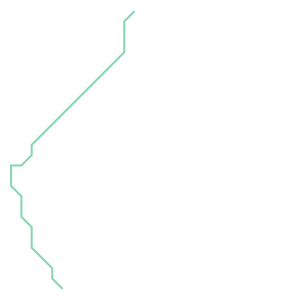

In [118]:
a

(611511.410843282, 2720317.579913143)

In [65]:
lines[2].coords[-1]

(611511.410843282, 2720317.579913143)

In [109]:
a = polygonize_full(MultiLineString(lines))

[]

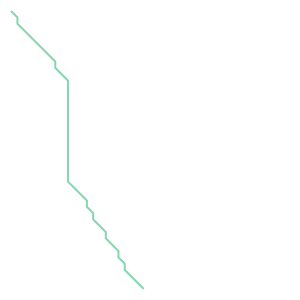

In [108]:
a[1]

In [1427]:
reload_islandmap = False

if reload_islandmap:

    src_ds = gdal.Open('../../GIS/ganges_metrics/island_map_HD.tif')

    try:
        srcband = src_ds.GetRasterBand(1)
    except RuntimeError, e:
        # for example, try GetRasterBand(10)
        print 'Band ( %i ) not found' % band_num
        print e
        sys.exit(1)

    raster = srcband.ReadAsArray()

    ulx, xres, xskew, uly, yskew, yres  = src_ds.GetGeoTransform()
    lrx = ulx + (src_ds.RasterXSize * xres)
    lry = uly + (src_ds.RasterYSize * yres)

    r_xmax, r_xmin, r_ymax, r_ymin = lrx, ulx, uly, lry
    pixel_size = xres

In [21]:
save_islandmap = False
island_props_arrays = False
save_island_props_pickles = False

if save_islandmap:

    rasterOrigin = (r_xmin, r_ymin)
    pixelWidth = r_xres * 5
    pixelHeight = r_xres * 5
    newRasterfn = '../../GIS/ganges_metrics/island_map_HD.tif'
    array = islandmap1

    reversed_arr = array[::-1] # reverse array so the tif looks like the array
    array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,reversed_arr) # convert array to raster

    
if island_props_arrays:
    
    island_aspect_ratio = np.zeros(vel.shape)
    island_area = np.zeros(vel.shape)
    island_edge_dist = np.zeros(vel.shape)
    island_shape_factor = np.zeros(vel.shape)

    for n, v in enumerate(island_props['label']): 
        island_aspect_ratio[islandmap == v] = island_props['aspect_ratio'][n]
        island_area[islandmap == v] = island_props['area'][n]
        island_edge_dist[islandmap == v] = island_props['edge_dist'][n]
        island_shape_factor[islandmap == v] = island_props['shape_factor'][n]
        
        
if save_island_props_pickles:
    
    pickle.dump(island_aspect_ratio, open( '../../GIS/ganges_metrics/island_aspect_ratio' + '.p', "wb" ) )
    pickle.dump(island_area, open( '../../GIS/ganges_metrics/island_area' + '.p', "wb" ) )
    pickle.dump(island_edge_dist, open( '../../GIS/ganges_metrics/island_edge_dist' + '.p', "wb" ) )
    pickle.dump(island_shape_factor, open( '../../GIS/ganges_metrics/island_shape_factor' + '.p', "wb" ) )

In [192]:
get_polygons_from_islandmap = False

if get_polygons_from_islandmap:

    geoms = []

    for label in range(3,islandmap.max()):
        if np.sum((islandmap == label)) > 10:

            print label

            # image = gaussian_filter((islandmap == label) * 1., 1).astype('int16')
            image = (islandmap == label).astype('int16')
            geom = [{'properties': {'raster_val': v}, 'geometry': s}
                    for i, (s, v) in enumerate(shapes(image))]
            try:
                geoms.append(geom[-2])
            except:
                pass


    islands = []

    for i in range(len(geoms)):

        polygon = shape(geoms[i]['geometry'])
        polygon = transform(lambda x, y, z=None: (x*r_xres+r_xmin, r_ymax - y*r_xres), polygon)
        islands.append(polygon)

    pickle.dump(geoms, open( '../../GIS/ganges_metrics/island_polygons' + '.p', "wb" ) )

In [1109]:
# c = fiona.open('../../GIS/ganges_metrics/nodes.shp')

# network_nodes = MultiPoint([shape(pol['geometry']) for pol in c])
# network_node_cat = [line['properties']['cat'] for line in c]


# node_nums = []
# dangle = []

# for l in network_lines:

#     c1 = Point(l.coords[0]).buffer(10)
#     c2 = Point(l.coords[-1]).buffer(10)

#     nearest_pt1 = [c1.intersects(pt) for pt in network_nodes]
#     nearest_pt2 = [c2.intersects(pt) for pt in network_nodes]
    
    
#     try:
#         node_num1 = np.where(np.array(nearest_pt1))[0][0]
#         cat1 = network_node_cat[node_num1]
#     except:
#         node_num1 = None
#         cat1 = None
    
#     try:
#         node_num2 = np.where(np.array(nearest_pt2))[0][0]
#         cat2 = network_node_cat[node_num2]
#     except:
#         node_num2 = None
#         cat2 = None
    
#     node_nums.append([node_num1, node_num2])
#     dangle.append([cat1, cat2])



# tribs = [n for n,i in enumerate(dangle) if max(i) == 1]


# for polygon in islands:

#     ch = polygon.convex_hull
#     near_channels = [n for n,l in enumerate(network_lines) if ch.intersects(l)]

#     for i in near_channels:

#         l = network_lines[i]

#         c1 = Point(l.coords[0]).buffer(10)
#         c2 = Point(l.coords[-1]).buffer(10)

#         inside = c1.intersects(polygon) or c2.intersects(polygon)
        
# #         inside = l.distance(polygon) < 10

#         if inside:
#             tribs.append(i)



# not_tribs = [n for n in range(len(network_lines)) if n not in tribs]

# island_indices = np.zeros((len(not_tribs),2))
# distances = np.zeros((len(not_tribs),2))
# dists = np.zeros((len(islands),))

# for n,i in enumerate(not_tribs):

#     l = network_lines[i]
#     dists[:] = 0

#     for ni,p in enumerate(islands):
#         dists[ni] = l.distance(p)

#     x = np.argsort(dists)

#     distances[n,:] = [dists[x[0]], dists[x[1]]]
#     island_indices[n,:] = [x[0], x[1]]



# too_close = [i for n,i in enumerate(not_tribs) if min(distances[n]) < 10]
# tribs = np.unique(tribs + too_close)

# not_tribs = [n for n in range(len(network_lines)) if n not in tribs]